**Names of all group members:**
Nils Johnson, Matteo Bodmer, Hai-Yen Van, Lucas Gimeno, Jonas Isler

---

All code below is only suggestive and you may as well use different approaches.

In [14]:
# Exercise 1.
import numpy as np
np.random.seed(0)  # for reproducibility

# simulate explanatory variables x (the age and monthly income are assumed here to follow a continous uniform distribution)

# training data
m = 20000
# test data
n = 10000

# initialize data matrix
data = np.zeros((m+n,3))

# first feature of data is age between [18,80] sampled from uniform distribution
data[:,0] = np.random.uniform(18,80,(m+n))

# second feature of data is the monthly income in CHF 1000 in [1,15] sampled from uniform distribution
data[:,1] = np.random.uniform(1,15,(m+n))

# third feature is a binary probality of being slaraied / self-employed. Probability of being self employed is 10%
data[:,2] = np.random.choice([0,1],p=[0.9,0.1],size=(m+n))

# a) calculate empirical means and standard deviations over training data

mean_train_feature_1 = np.mean(data[:m,0])
mean_train_feature_2 = np.mean(data[:m,1])
mean_train_feature_3 = np.mean(data[:m,2])

std_train_feature_1 = np.std(data[:m,0])
std_train_feature_2 = np.std(data[:m,1])
std_train_feature_3 = np.std(data[:m,2])

# b) Can you come up with a few (2 or 3) additional features that may be relevant?
# (you don't have to implement those of course, just write down your answer in text)
# Employment and income details: Income volatility, contract type, emplyment tenure (years with current employer)
# Liabilities: Outstanding debt, number of active credit lines, credit scores
# Collateral: Savings and  investment balances


In [15]:
# Exercise 2.
# Building the datasets:

sigmoid = lambda x: 1. / (1. + np.exp(-x))

x1, x2, x3 = data[:, 0], data[:, 1], data[:, 2]

p1 = sigmoid(13.3 - 0.33*x1 + 3.5*x2 - 3*x3)

def p2(x):
    age, income, emp = x[:,0], x[:,1], x[:,2]
    indicator_1 = (age < 25).astype(float)
    indicator_2 = (age > 75).astype(float)
    z = 5 - 10*indicator_1 + 10*indicator_2 + 1.1*income - emp
    return sigmoid(z)

epsilon = np.random.uniform(size=(m+n))
# build the first dataset

y_1 = (p1 >= epsilon).astype(int)

# build the second dataset
y_2 = (p2(data) >= epsilon).astype(int)


In [17]:
# Exercise 2. a)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
# "model = LogisticRegression().fit(X_data, Y_data)" fits a model
# "pred_X = model.predict_proba(X)" evaluates the model
# (note that it outputs both P(Y=0|X) and P(Y=1|X))
# "log_loss(Y, pred_X)" evaluates the negative conditional log likelihood (also called cross-entropy loss)


# Fit the models on both datasets
model_1 = LogisticRegression().fit(data[:m,:],y_1[:m])
model_2 = LogisticRegression().fit(data[:m,:],y_2[:m])

# evaluate both models on the data, we only need the positive class to calculate the cross-entropy loss
pred_train_1 = model_1.predict_proba(data[:m,:])[:,1]
pred_train_2 = model_2.predict_proba(data[:m,:])[:,1]

pred_test_1 = model_1.predict_proba(data[m:,:])[:,1]
pred_test_2 = model_2.predict_proba(data[m:,:])[:,1]

# Calculate cross-entropy loss on both datasets for train and test
cross_entropy_train_1 = log_loss(y_1[:m], pred_train_1)
cross_entropy_train_2 = log_loss(y_2[:m], pred_train_2)

cross_entropy_test_1 = log_loss(y_1[m:], pred_test_1)
cross_entropy_test_2 = log_loss(y_2[m:], pred_test_2)

print("=== Cross-Entropy (Log Loss) Results ===")
print(f"Dataset 1 - Train loss: {cross_entropy_train_1:.4f}")
print(f"Dataset 1 - Test  loss: {cross_entropy_test_1:.4f}")
print()
print(f"Dataset 2 - Train loss: {cross_entropy_train_2:.4f}")
print(f"Dataset 2 - Test  loss: {cross_entropy_test_2:.4f}")


=== Cross-Entropy (Log Loss) Results ===
Dataset 1 - Train loss: 0.0297
Dataset 1 - Test  loss: 0.0349

Dataset 2 - Train loss: 0.0384
Dataset 2 - Test  loss: 0.0330


In [18]:
# Exercise 2. b)
# Calculate normalized data

data_norm = np.zeros(((m+n),3))

data_norm[:,0] = data[:,0]/std_train_feature_1
data_norm[:,1] = data[:,1]/std_train_feature_2
data_norm[:,2] = data[:,2]/std_train_feature_3

In [19]:
# Exercise 2.b) (i) and (ii)
from sklearn.svm import SVC
# "model = SVC(kernel='rbf', gamma=GAMMA, C=C, probability=True)" creates
# a model with kernel exp(-GAMMA \|x-x'\|_2^2) and regul. parameter C (note the relation between C and the parameter lambda from the lecture).
# "probability=True" enables the option "model.predict_proba(X)" to predict probabilities from the regression function \hat{f}^{svm}.
# "model.fit(X, Y)" optimizes the model parameters (using hinge loss)

# Fit the models for both datasets (this can take up to 60 seconds with SVC)
model_svm_1 = SVC(kernel='rbf', gamma = 0.1, C= 0.2, probability=True).fit(data_norm[:m,:],y_1[:m])
model_svm_2 = SVC(kernel='rbf', gamma= 0.1, C=0.2, probability=True).fit(data_norm[:m,:],y_2[:m])


In [20]:
# Exercise 2.b (iii)
# "model.predict_proba(X)" predicts probabilities from features (note that it outputs both P(Y=0|X) and P(Y=1|X))
pred_svm_train_1 = model_svm_1.predict_proba(data_norm[:m,:])[:,1]
pred_svm_train_2 = model_svm_2.predict_proba(data_norm[:m,:])[:,1]

pred_svm_test_1 = model_svm_1.predict_proba(data_norm[m:,:])[:,1]
pred_svm_test_2 = model_svm_2.predict_proba(data_norm[m:,:])[:,1]

# Calculate cross-entropy loss on both normalized datasets for train and test
cross_entropy_svm_train_1 = log_loss(y_1[:m], pred_svm_train_1)
cross_entropy_svm_train_2 = log_loss(y_2[:m], pred_svm_train_2)

cross_entropy_svm_test_1 = log_loss(y_1[m:], pred_svm_test_1)
cross_entropy_svm_test_2 = log_loss(y_2[m:], pred_svm_test_2)

print("=== Cross-Entropy (Log Loss) Results for RKHS (SVM) Models ===")
print(f"Dataset 1 - Train loss: {cross_entropy_svm_train_1:.4f}")
print(f"Dataset 1 - Test  loss: {cross_entropy_svm_test_1:.4f}")
print()
print(f"Dataset 2 - Train loss: {cross_entropy_svm_train_2:.4f}")
print(f"Dataset 2 - Test  loss: {cross_entropy_svm_test_2:.4f}")

=== Cross-Entropy (Log Loss) Results for RKHS (SVM) Models ===
Dataset 1 - Train loss: 0.0319
Dataset 1 - Test  loss: 0.0388

Dataset 2 - Train loss: 0.0411
Dataset 2 - Test  loss: 0.0354


In [ ]:
# Exercise 2.b (iv)
#Would the results change using standardized data instead of normalized data? No need to run any code here, only explain your reasoning.

# I don't think so.
# The rbf kernel depends on pairwise distances between points. 
# If we standardize the data (subtract the mean and divide by std), 
# we only shift all points by a constant mean vector compared to simple normalization (dividing by std). 
# Since distances between points don't change by shifting, the results should be the same.

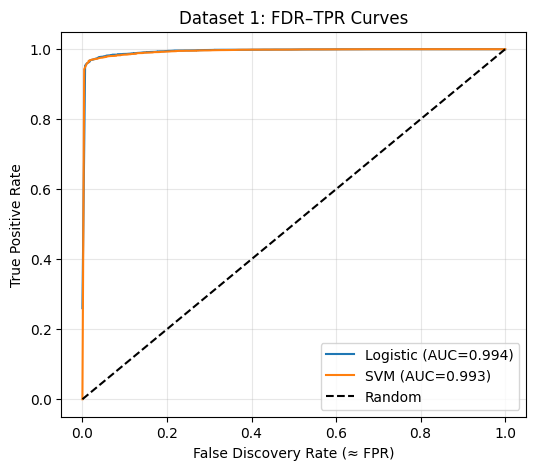

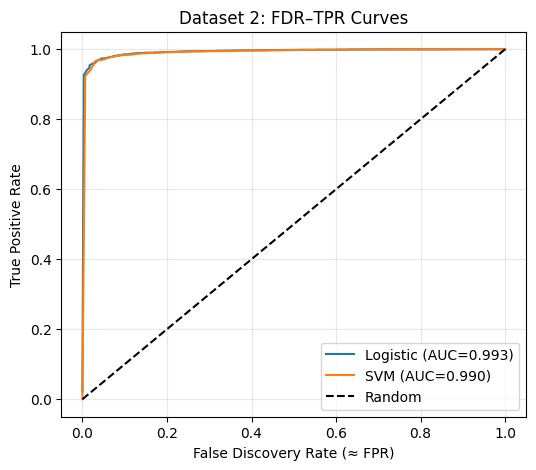

AUC Summary 
Dataset 1 : Logistic Regression: 0.994
Dataset 1 : RHKS: 0.993
Dataset 2 : Logistic Regression: 0.993
Dataset 2 : RHKS: 0.990


In [21]:
# Exercise 2.c
import matplotlib.pyplot as plt
# To calculate the curves, it is fine to take 100 threshold values c, i.e.,
ths = np.linspace(0, 1, 100)

# To approximately calculate the AUC, it is fine to simply use Riemann sums.
# This means, if you have 100 (a_i, b_i) pairs for the curves, a_1 <= a_2 <= ...
# then you may simply use the sum
# sum_{i=1}^99 (b_i + b_{i+1})/2 * (a_{i+1}-a_i)
# as the approximation of the integral (or AUC)


def fdr_tpr(y_true, y_score, thresholds):
    
    # number of positives
    P = np.sum(y_true == 1)
    # number of negatives
    N = np.sum(y_true == 0)  

    TPR_list, FDR_list = [], []

    for c in thresholds:
        # predicted class given threshold
        y_pred = (y_score >= c).astype(int)

        TP = np.sum((y_pred == 1) & (y_true == 1))
        FP = np.sum((y_pred == 1) & (y_true == 0))

        TPR = TP / P if P > 0 else 0
        FDR = FP / N if N > 0 else 0

        TPR_list.append(TPR)
        FDR_list.append(FDR)

    return np.array(FDR_list), np.array(TPR_list)

def auc(FDR, TPR):
    # Sort by FDR so integration works
    order = np.argsort(FDR)
    return np.trapezoid(TPR[order], FDR[order])


# dataset 1, logistic reg.
FDR_logreg1, TPR_logreg1 = fdr_tpr(y_1[m:], pred_test_1, ths)
AUC_logreg1 = auc(FDR_logreg1, TPR_logreg1)

# dataset 2, logistic reg.
FDR_logreg2, TPR_logreg2 = fdr_tpr(y_2[m:], pred_test_2, ths)
AUC_logreg2 = auc(FDR_logreg2, TPR_logreg2)

# dataset 1, rhks
FDR_rhks1, TPR_rhks1 = fdr_tpr(y_1[m:], pred_svm_test_1, ths)
AUC_rhks1 = auc(FDR_rhks1, TPR_rhks1)

# dataset 2, rhks
FDR_rhks2, TPR_rhks2 = fdr_tpr(y_2[m:], pred_svm_test_2, ths)
AUC_rhks2 = auc(FDR_rhks2, TPR_rhks2)

# plot Dataset 1 
plt.figure(figsize=(6,5))
plt.plot(FDR_logreg1, TPR_logreg1, label=f"Logistic (AUC={AUC_logreg1:.3f})")
plt.plot(FDR_rhks1, TPR_rhks1, label=f"SVM (AUC={AUC_rhks1:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Discovery Rate (≈ FPR)")
plt.ylabel("True Positive Rate")
plt.title("Dataset 1: FDR–TPR Curves")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# plot Dataset 2
plt.figure(figsize=(6,5))
plt.plot(FDR_logreg2, TPR_logreg2, label=f"Logistic (AUC={AUC_logreg2:.3f})")
plt.plot(FDR_rhks2, TPR_rhks2, label=f"SVM (AUC={AUC_rhks2:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Discovery Rate (≈ FPR)")
plt.ylabel("True Positive Rate")
plt.title("Dataset 2: FDR–TPR Curves")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

#summary 
print("AUC Summary ")
print(f"Dataset 1 : Logistic Regression: {AUC_logreg1:.3f}")
print(f"Dataset 1 : RHKS: {AUC_rhks1:.3f}")
print(f"Dataset 2 : Logistic Regression: {AUC_logreg2:.3f}")
print(f"Dataset 2 : RHKS: {AUC_rhks2:.3f}")

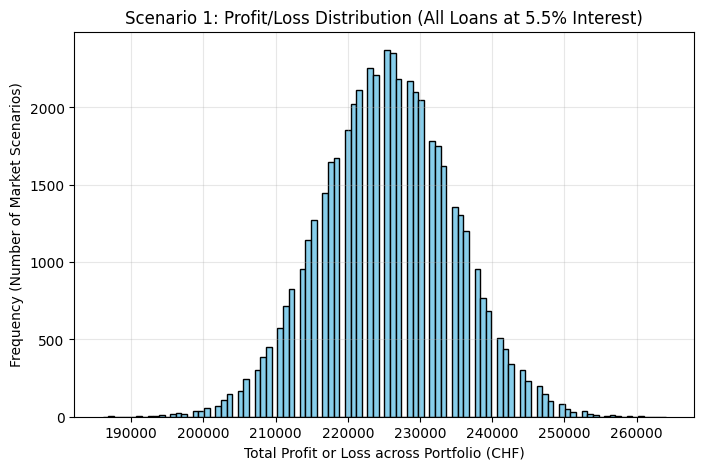

95%-VaR (Scenario 1): 210290.00 CHF


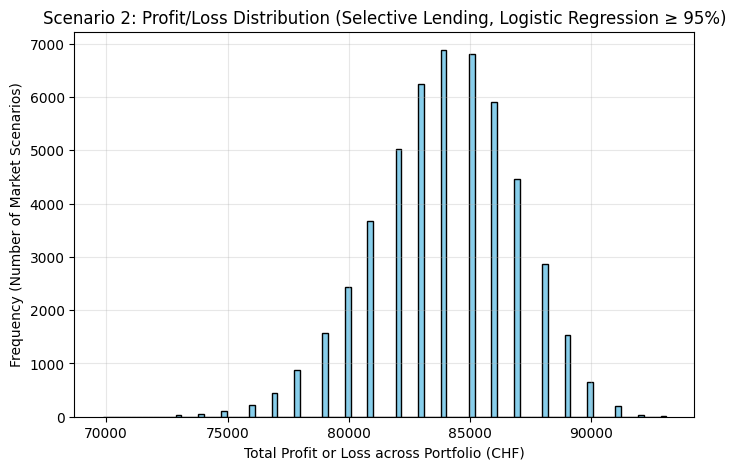

95%-VaR (Scenario 2): 78940.00 CHF


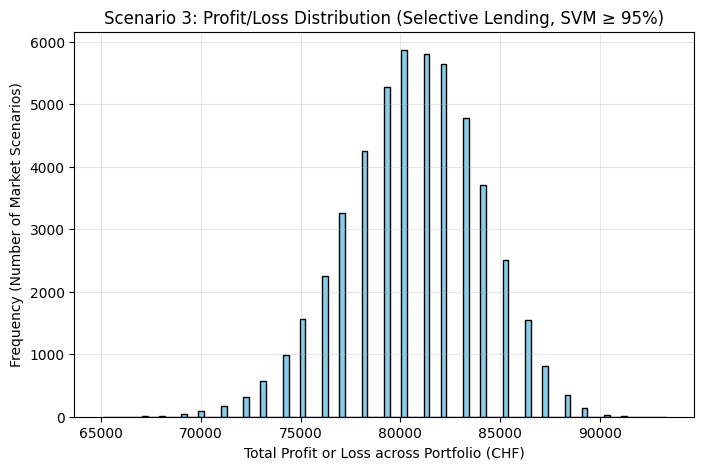

95%-VaR (Scenario 3): 75160.00 CHF

Summary of Strategies:
Strategy (i)  All loans:      Expected income = 225514.56 CHF, 95%-VaR = 210290.00 CHF
Strategy (ii) LogReg select:  Expected income = 83992.04 CHF, 95%-VaR = 78940.00 CHF
Strategy (iii) SVM select:    Expected income = 80658.95 CHF, 95%-VaR = 75160.00 CHF


In [24]:
# Exercise 3.

# Set model parameters and define matrix D
k = 50000

D = np.random.uniform(0, 1, size=(n, k))
p2_vals = p2(data)[m:]
D = (D <= p2_vals[:, None])

# Scenario 1:
# Define Portfolio and possible outcomes for this portfolio using matrix D
loan = 1000
interest = 0.055
profit_1 = interest*loan

# add repayment or loss to the scenarios of D
D_1 = np.where(D == 1, profit_1, -1*loan)

net_income_1 = D_1.sum(axis=0)
mean_profit_1 = np.mean(net_income_1)

# Plot histogram of profits and losses
plt.figure(figsize=(8,5))
plt.hist(net_income_1, bins=100, edgecolor="black", color="skyblue")
plt.title("Scenario 1: Profit/Loss Distribution (All Loans at 5.5% Interest)")
plt.xlabel("Total Profit or Loss across Portfolio (CHF)")
plt.ylabel("Frequency (Number of Market Scenarios)")
plt.grid(alpha=0.3)
plt.show()

# Calculate expected profit and losses and 95%-VaR
VaR_95_1 = np.quantile(net_income_1, 0.05)
print(f"95%-VaR (Scenario 1): {VaR_95_1:.2f} CHF")


# Scenario 2:
# Define Portfolio and possible outcomes using the matrix D and the predicted default probabilities from the logistic regression model
interest_2 = 0.01
profit_2 = interest_2*loan

# refill D according to the cases where loans where given
D_2 = D[pred_test_2 >= 0.95,:]

# add repayment or loss to the scenarios of D_2
D_2 = np.where(D_2 == 1, profit_2, -1*loan)

net_income_2 = D_2.sum(axis=0)

mean_profit_2 = np.mean(net_income_2)

# Plot histogram of profits and losses
plt.figure(figsize=(8,5))
plt.hist(net_income_2, bins=100, edgecolor="black", color="skyblue")
plt.title("Scenario 2: Profit/Loss Distribution (Selective Lending, Logistic Regression ≥ 95%)")
plt.xlabel("Total Profit or Loss across Portfolio (CHF)")
plt.ylabel("Frequency (Number of Market Scenarios)")
plt.grid(alpha=0.3)
plt.show()

# Calculate expected profit and losses and 95%-VaR
VaR_95_2 = np.quantile(net_income_2, 0.05)
print(f"95%-VaR (Scenario 2): {VaR_95_2:.2f} CHF")

# Scenario 3:
# Define Portfolio and possible outcomes using the matrix D and the predicted default probabilities from the rkhs model
interest_3 = 0.01
profit_3 = loan*interest_3

# refill D according to the cases where loans where given
D_3 = D[pred_svm_test_2 >= 0.95,:]

# add repayment or loss to the scenarios of D_3
D_3 = np.where(D_3 == 1, profit_3, -1*loan)

net_income_3 = D_3.sum(axis=0)
mean_profit_3 = np.mean(net_income_3)

# Plot histogram of profits & losses (which is simply the performance of each strategy in scenario k, i.e. a profit if positive or a loss if negative)
plt.figure(figsize=(8,5))
plt.hist(net_income_3, bins=100, edgecolor="black", color="skyblue")
plt.title("Scenario 3: Profit/Loss Distribution (Selective Lending, SVM ≥ 95%)")
plt.xlabel("Total Profit or Loss across Portfolio (CHF)")
plt.ylabel("Frequency (Number of Market Scenarios)")
plt.grid(alpha=0.3)
plt.show()

# Calculate expected profit & losses and 95%-VaR for each strategy
VaR_95_3 = np.quantile(net_income_3, 0.05)
print(f"95%-VaR (Scenario 3): {VaR_95_3:.2f} CHF")

print("\nSummary of Strategies:")
print(f"Strategy (i)  All loans:      Expected income = {mean_profit_1:.2f} CHF, 95%-VaR = {VaR_95_1:.2f} CHF")
print(f"Strategy (ii) LogReg select:  Expected income = {mean_profit_2:.2f} CHF, 95%-VaR = {VaR_95_2:.2f} CHF")
print(f"Strategy (iii) SVM select:    Expected income = {mean_profit_3:.2f} CHF, 95%-VaR = {VaR_95_3:.2f} CHF")